# 数据处理代码测试

In [13]:
import logging

import numpy as np

from config_loader import load_data_config
from data_preprocess import load_data
import pandas as pd

# 假设您已经定义了 create_dataloader 和 load_data 函数
try:
    datasets = ['NASA', 'CALCE']
    for dataset in datasets:
        data_config, val_bat, test_bat, bats, lookback_len, pred_len, rated_capacity, fail_soh, batch_size = load_data_config(dataset)
        data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')
        train_loader, val_loader, test_loader = load_data(data_df, val_bat, test_bat, lookback_len, pred_len, batch_size)
        print("数据加载器创建成功！")
        # 尝试从 DataLoader 中获取一些数据来看是否正确
        for data in train_loader:
            print("训练数据示例：", data)
            break
        for data in val_loader:
            print("验证数据示例：", data)
            break
        for data in test_loader:
            print("测试数据示例：", data)
            break
except Exception as e:
    print("在数据处理过程中发生错误：", str(e))

数据加载器创建成功！
训练数据示例： [tensor([[0.8438, 0.8415, 0.8390, 0.8366, 0.8337, 0.8311, 0.8287, 0.8263, 0.8236,
         0.8182, 0.8181, 0.8206, 0.8158, 0.8106, 0.8082, 0.8079],
        [0.7533, 0.7507, 0.7482, 0.7667, 0.7619, 0.7506, 0.7462, 0.7417, 0.7404,
         0.7368, 0.7340, 0.7290, 0.7239, 0.7264, 0.7213, 0.7196],
        [0.7975, 0.7952, 0.7927, 0.7900, 0.7876, 0.7849, 0.7851, 0.7826, 0.7798,
         0.7825, 0.7875, 0.7826, 0.7799, 0.7749, 0.7719, 0.7725],
        [0.9058, 0.9030, 0.9066, 0.9031, 0.8979, 0.8929, 0.8902, 0.9075, 0.9079,
         0.9001, 0.8952, 0.8902, 0.8877, 0.8851, 0.8800, 0.8748],
        [0.7620, 0.7593, 0.7568, 0.7568, 0.7570, 0.7670, 0.7696, 0.7618, 0.7568,
         0.7539, 0.7516, 0.7489, 0.7464, 0.7462, 0.7437, 0.7413],
        [0.9314, 0.9260, 0.9235, 0.9184, 0.9186, 0.9158, 0.9106, 0.9083, 0.9057,
         0.9058, 0.9030, 0.9066, 0.9031, 0.8979, 0.8929, 0.8902],
        [0.9300, 0.9296, 0.9241, 0.9246, 0.9417, 0.9314, 0.9260, 0.9235, 0.9184,
         0.9186, 

# 训练、验证、测试 - 多组实验

In [1]:
import torch
import torch.nn as nn
from data_preprocess import load_data
from train_util import get_model, set_seed, get_optimizer
from config_loader import load_common_config, load_data_config
import os
import pandas as pd
import time
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# 公共参数
models_config, seeds, device = load_common_config()

alpha = 1  # loss_soh 的比重
# datasets = ['NASA', 'CALCE']
datasets = ['CALCE']
# model_names = ['model_v1', 'model_v2', 'model_v2_1', 'model_v2_2', 'model_v3', 'model_v4', 'model_v4_1', 'model_v5']
model_names = ['model_v6']
save_model = False
seeds = seeds[1:2]
patience = 20  # 耐心值，即连续多少个epoch无改进时停止训练

for i in range(len(seeds)):
    set_seed(seeds[i])
    for dataset in datasets:
        # 加载数据
        data_config, val_bat, test_bat, lookback_len, pred_len, rated_capacity, batch_size = load_data_config(dataset)
        data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')    
        train_loader, val_loader, test_loader = load_data(data_df, val_bat, test_bat, lookback_len, pred_len, batch_size)

        for model_name in model_names:
            model_save_path = f"saved_models/{dataset}/{model_name}_s-{i+1}.pth"
            # 模型相关参数
            model_config = models_config[model_name]
            _, lr, optim_name, max_epochs, det_alpha, rmsprop_alpha = (
                model_config['batch_size'],
                model_config['lr'],
                model_config['optimizer'],
                model_config['max_epochs'],
                model_config.get('det_alpha', None),
                model_config.get('rmsprop_alpha', None)
            )
            model_config['lookback_len'] = lookback_len
            model_config['pred_len'] = pred_len
            
            model = get_model(model_config, device, lookback_len)
            # lr = 3e-4
            optimizer = get_optimizer(optim_name, model, lr, rmsprop_alpha)
            criterion_soh, criterion_rul = nn.MSELoss(), nn.MSELoss()
            
            # 训练
            train_losses = []
            val_losses = []
            test_losses = []
            best_val_loss = np.inf
            patience_counter = 0  # 耐心计数器
            for epoch in range(max_epochs):
                model.train()
                train_loss = 0.0
                for features, soh, rul in train_loader:
                    """
                    features: (batch_size, lookback_len, 1)
                    soh: (batch_size, pred_len)
                    rul: (batch_size,)
                    """
                    features, soh, rul = features.to(device), soh.to(device), rul.to(device)
                    optimizer.zero_grad()
                    soh_pred, rul_pred = model(features)
                    loss_soh = criterion_soh(soh_pred, soh)
                    loss_rul = criterion_rul(rul_pred, rul)
                    loss = alpha * loss_soh + loss_rul
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
                # 验证
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for features, soh, rul in val_loader:
                        soh_pred, rul_pred = model(features)
                        loss_soh = criterion_soh(soh_pred, soh)
                        loss_rul = criterion_rul(rul_pred, rul)
                        loss = alpha * loss_soh + loss_rul
                        val_loss += loss.item()
                    val_loss /= len(val_loader)
                val_losses.append(val_loss)
                        
                # 测试
                test_loss = 0.0
                test_soh_loss = 0.0
                test_rul_loss = 0.0
                with torch.no_grad():
                    for features, soh, rul in test_loader:
                        soh_pred, rul_pred = model(features)
                        loss_soh = criterion_soh(soh_pred, soh)
                        loss_rul = criterion_rul(rul_pred, rul)
                        loss = alpha * loss_soh + loss_rul
                        test_loss += loss.item()
                        test_soh_loss += loss_soh.item()
                        test_rul_loss += loss_rul.item()
                    test_loss /= len(test_loader)
                    test_soh_loss /= len(test_loader)
                    test_rul_loss /= len(test_loader)
                test_losses.append(test_loss)
                test_soh_rmse = torch.sqrt(torch.tensor(test_soh_loss))
                test_rul_rmse = torch.sqrt(torch.tensor(test_rul_loss))
                
                print(f"Seed: {i + 1}, Dataset: {dataset}, Model: {model_name}, Epoch: {epoch + 1:03d} | "
                      f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Test Loss: {test_loss:.5f} | "
                      f"Test SOH RMSE: {test_soh_rmse:.4f}, Test RUL RMSE: {test_rul_rmse:.4f}")
                
                # TODO 早停
                # TODO 结果保存为csv
                # 保存模型
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    if save_model:
                        torch.save(model.state_dict(), model_save_path)
                    print("New best model saved ...")
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered at Epoch", epoch + 1)
                        break


Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 001 | Train Loss: 0.24821, Val Loss: 0.09578, Test Loss: 0.05638 | Test SOH RMSE: 0.0797, Test RUL RMSE: 0.2237
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 002 | Train Loss: 0.03702, Val Loss: 0.09561, Test Loss: 0.03942 | Test SOH RMSE: 0.0522, Test RUL RMSE: 0.1915
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 003 | Train Loss: 0.01862, Val Loss: 0.09826, Test Loss: 0.01709 | Test SOH RMSE: 0.0436, Test RUL RMSE: 0.1232
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 004 | Train Loss: 0.01477, Val Loss: 0.09063, Test Loss: 0.01171 | Test SOH RMSE: 0.0422, Test RUL RMSE: 0.0996
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 005 | Train Loss: 0.01100, Val Loss: 0.08934, Test Loss: 0.01309 | Test SOH RMSE: 0.0412, Test RUL RMSE: 0.1067
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 006 | Train Loss: 0.01047, Val Loss: 0.09011, 

KeyboardInterrupt: 

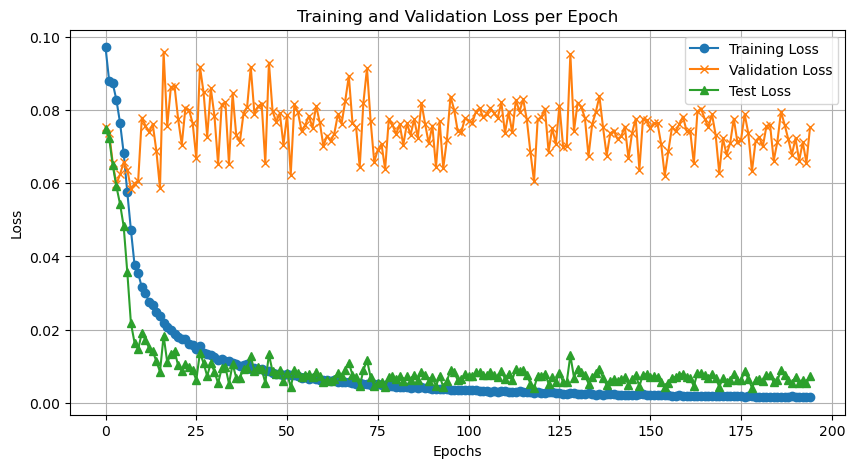

In [14]:
# 绘制图形
plt.figure(figsize=(10, 5))
start_epoch = 5
plt.plot(train_losses[start_epoch:], label='Training Loss', marker='o')
plt.plot(val_losses[start_epoch:], label='Validation Loss', marker='x')
plt.plot(test_losses[start_epoch:], label='Test Loss', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

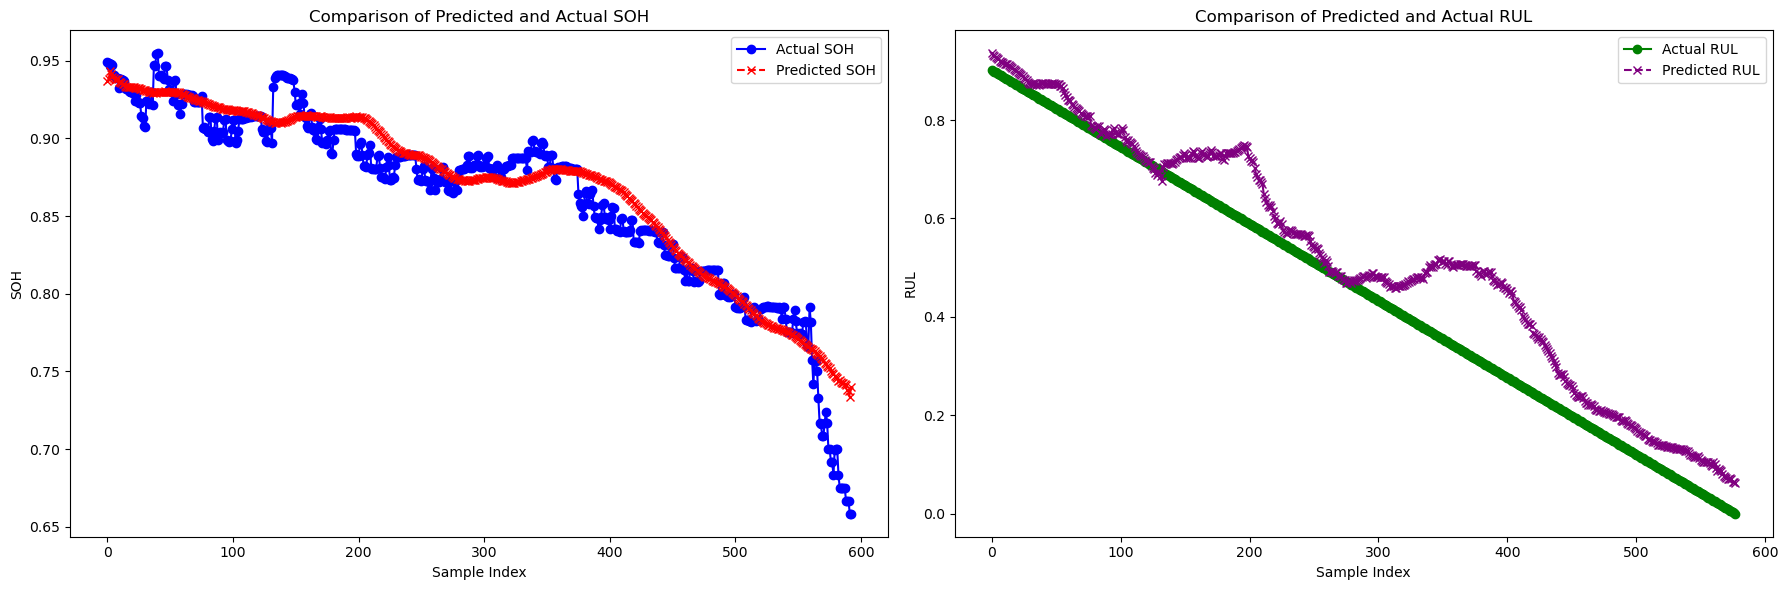

In [15]:
predictions_by_time = defaultdict(list)
true_by_time = defaultdict(list)
rul_preds = []
rul_true = []

with torch.no_grad():
    time_step = 0  # 初始化时间步
    for features, soh, rul in test_loader:
        soh_pred, rul_pred = model(features)
        
        # 转换为numpy数组以方便处理
        soh_pred = np.array(soh_pred)
        soh = np.array(soh)
        # 更新predictions_by_time
        for i in range(soh_pred.shape[0]):  # 遍历batch中的每个样本
            current_base_time = time_step + i
            for j in range(pred_len):  # 遍历每个样本的所有预测步
                predictions_by_time[current_base_time + j].append(soh_pred[i, j])
                true_by_time[current_base_time + j].append(soh[i, j])
        time_step += soh_pred.shape[0]  # 更新时间步
        
        rul_preds.extend(rul_pred.flatten().tolist())
        rul_true.extend(rul.tolist())

# 计算平均预测
average_predictions = {t: np.mean(vals) for t, vals in predictions_by_time.items()}
average_true = {t: np.mean(vals) for t, vals in true_by_time.items()}
soh_preds = list(average_predictions.values())
soh_true = list(average_true.values())

# 绘制SOH的预测与实际值对比图
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(soh_true, label='Actual SOH', color='blue', marker='o')
plt.plot(soh_preds, label='Predicted SOH', color='red', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual SOH')
plt.xlabel('Sample Index')
plt.ylabel('SOH')
plt.legend()

# 绘制RUL的预测与实际值对比图
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(rul_true, label='Actual RUL', color='green', marker='o')
plt.plot(rul_preds, label='Predicted RUL', color='purple', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.show()

# 交叉验证

In [4]:
import torch
import torch.nn as nn
from data_preprocess import load_data
from train_util import get_model, set_seed, get_optimizer
from config_loader import load_common_config, load_data_config
import os
import pandas as pd
import time
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math

In [39]:
# 公共参数
models_config, seeds, device = load_common_config()

alpha = 0.1  # loss_soh 的比重
# datasets = ['NASA', 'CALCE']
datasets = ['CALCE']
# model_names = ['model_v1', 'model_v2', 'model_v2_1', 'model_v2_2', 'model_v3', 'model_v4', 'model_v4_1', 'model_v5']
model_names = ['model_v6']
save_model = False
seeds = seeds[0:1]
patience = 20  # 耐心值，即连续多少个epoch无改进时停止训练
result_path = "result/search_param.csv"

use_config = False
ks = [2, 3, 5, 7]
depth = [1, 2, 3, 4]
num_layers = [1, 2, 3, 4]
num_heads = [1, 2, 4, 8]

for k in ks:
    for d in depth:
        for l in num_layers:
            for h in num_heads:
                for i in range(len(seeds)):
                    set_seed(seeds[i])
                    for dataset in datasets:
                        # 加载数据
                        data_config, _, _, bats, lookback_len, pred_len, rated_capacity, batch_size = load_data_config(dataset)
                        data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')    
                        for bat in bats:
                            val_bat = bat
                            train_loader, val_loader, _ = load_data(data_df, val_bat, None, lookback_len, pred_len, batch_size)
                    
                            for model_name in model_names:
                                model_save_path = f"saved_models/{dataset}/{model_name}_s-{i+1}.pth"
                                # 模型相关参数
                                model_config = models_config[model_name]
                                _, lr, optim_name, max_epochs, det_alpha, rmsprop_alpha = (
                                    model_config['batch_size'],
                                    model_config['lr'],
                                    model_config['optimizer'],
                                    model_config['max_epochs'],
                                    model_config.get('det_alpha', None),
                                    model_config.get('rmsprop_alpha', None)
                                )
                                model_config['lookback_len'] = lookback_len
                                model_config['pred_len'] = pred_len
                                if not use_config:
                                    model_config['kernel_size'] = ks
                                    model_config['depth'] = depth
                                    model_config['num_layers'] = num_layers
                                    model_config['num_heads'] = num_heads
                                
                                model = get_model(model_config, device, lookback_len)
                                # lr = 3e-4
                                optimizer = get_optimizer(optim_name, model, lr, rmsprop_alpha)
                                criterion_soh, criterion_rul, criterion_rec = nn.MSELoss(), nn.MSELoss(), nn.MSELoss()
                                
                                # 训练
                                train_losses = []
                                val_losses = []
                                test_losses = []
                                best_metric = np.inf
                                patience_counter = 0  # 耐心计数器
                                start_time = time.time()
                                for epoch in range(max_epochs):
                                    model.train()
                                    train_loss = 0.0
                                    for features, soh, rul in train_loader:
                                        """
                                        features: (batch_size, lookback_len, 1)
                                        soh: (batch_size, pred_len)
                                        rul: (batch_size,)
                                        """
                                        features, soh, rul = features.to(device), soh.to(device), rul.to(device)
                                        optimizer.zero_grad()
                                        if model_name == 'det':
                                            soh_pred, rul_pred, decodes = model(features.transpose(1, 2).repeat(1, model_config['feature_num'], 1))
                                        else:
                                            soh_pred, rul_pred = model(features)
                                        loss_soh = criterion_soh(soh_pred, soh)
                                        loss_rul = criterion_rul(rul_pred, rul)
                                        loss = alpha * loss_soh + loss_rul
                                        if model_name == 'det':
                                            loss += model_config['det_alpha'] * criterion_rec(features.transpose(1, 2).repeat(1, model_config['feature_num'], 1), decodes)
                                        loss.backward()
                                        optimizer.step()
                                        train_loss += loss.item()
                                    train_loss /= len(train_loader)
                                    train_losses.append(train_loss)
                                    
                                    # 验证
                                    model.eval()
                                    val_loss, val_soh_loss, val_rul_loss = 0.0, 0.0, 0.0
                                    with torch.no_grad():
                                        for features, soh, rul in val_loader:
                                            if model_name == 'det':
                                                soh_pred, rul_pred, decodes = model(features.transpose(1, 2).repeat(1, model_config['feature_num'], 1))
                                            else:
                                                soh_pred, rul_pred = model(features)
                                            loss_soh = criterion_soh(soh_pred, soh)
                                            loss_rul = criterion_rul(rul_pred, rul)
                                            loss = alpha * loss_soh + loss_rul
                                            if model_name == 'det':
                                                loss += model_config['det_alpha'] * criterion_rec(features.transpose(1, 2).repeat(1, model_config['feature_num'], 1), decodes)
                                            val_loss += loss.item()
                                            val_soh_loss += loss_soh.item()
                                            val_rul_loss += loss_rul.item()
                                        val_loss /= len(val_loader)
                                        val_soh_loss /= len(val_loader)
                                        val_rul_loss /= len(val_loader)
                                    val_losses.append(val_loss)
                                    val_soh_rmse = np.sqrt(val_soh_loss)
                                    val_rul_rmse = np.sqrt(val_rul_loss)
                                    
                                    print(f"Seed: {i + 1}, Dataset: {dataset}, Val Bat: {val_bat}, Model: {model_name}, Epoch: {epoch + 1:03d} | "
                                          f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f} | "
                                          f"Val SOH RMSE: {val_soh_rmse:.4f}, Val RUL RMSE: {val_rul_rmse:.4f}")
                
                                    # TODO 结果保存为csv
                                    # 保存模型
                                    if val_rul_loss < best_metric:
                                        best_train_loss = train_loss
                                        best_val_loss = val_loss
                                        best_val_soh_rmse = val_soh_rmse
                                        best_val_rul_rmse = val_rul_rmse
                                        best_metric = val_rul_loss
                                        patience_counter = 0
                                        if save_model:
                                            torch.save(model.state_dict(), model_save_path)
                                        print("New best model saved ...")
                                    else:
                                        patience_counter += 1
                                        if patience_counter >= patience:
                                            print("Early stopping triggered at Epoch", epoch + 1)
                                            
                                            # 保存结果
                                            end_time = time.time()
                                            duration = end_time - start_time
                                            result = {
                                                'dataset': dataset,
                                                'ks': model_config['kernel_size'],
                                                'depth': model_config['depth'],
                                                'num_layers': model_config['num_layers'],
                                                'num_heads': model_config['num_heads'],
                                                'val_bat': val_bat,
                                                'train_loss': best_train_loss,
                                                'val_loss': best_val_loss,
                                                'val_soh_rmse': best_val_soh_rmse,
                                                'val_rul_rmse': best_val_rul_rmse,
                                                'epochs': epoch + 1 - patience_counter,
                                                'time_per_epoch': duration / (epoch + 1)
                                            }
                                            columns = ['dataset', 'ks', 'depth', 'num_layers', 'num_heads', 'val_bat','train_loss', 'val_loss', 'val_soh_rmse', 'val_rul_rmse', 'epochs', 'time_per_epoch']
                                            # csv文件不存在时，先创建，并定义表头
                                            if not os.path.exists(result_path):
                                                df = pd.DataFrame(columns=columns)
                                                df.to_csv(result_path, index=False)
                                            pd.DataFrame(result).to_csv(result_path, header=False, index=False)
                                            break


Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 001 | Train Loss: 0.05406, Val Loss: 0.00928 | Val SOH RMSE: 0.0554, Val RUL RMSE: 0.0947
New best model saved ...
Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 002 | Train Loss: 0.01450, Val Loss: 0.01312 | Val SOH RMSE: 0.0294, Val RUL RMSE: 0.1142
Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 003 | Train Loss: 0.01571, Val Loss: 0.00849 | Val SOH RMSE: 0.0229, Val RUL RMSE: 0.0919
New best model saved ...
Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 004 | Train Loss: 0.01511, Val Loss: 0.02049 | Val SOH RMSE: 0.0439, Val RUL RMSE: 0.1425
Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 005 | Train Loss: 0.01561, Val Loss: 0.00600 | Val SOH RMSE: 0.0255, Val RUL RMSE: 0.0770
New best model saved ...
Seed: 1, Dataset: CALCE, Val Bat: CS2_35, Model: model_v6, Epoch: 006 | Train Loss: 0.01391, Val Loss: 0.00742 | Val SOH RMSE: 0.0257, Val RUL RM

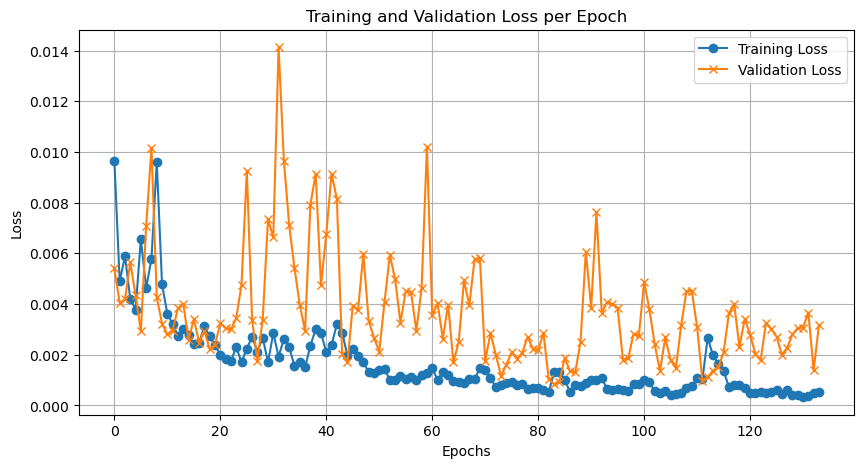

In [27]:
# 绘制图形
plt.figure(figsize=(10, 5))
start_epoch = 10
plt.plot(train_losses[start_epoch:], label='Training Loss', marker='o')
plt.plot(val_losses[start_epoch:], label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
model = get_model(model_config, device, lookback_len)
model.load_state_dict(torch.load(model_save_path, weights_only=True))

<All keys matched successfully>

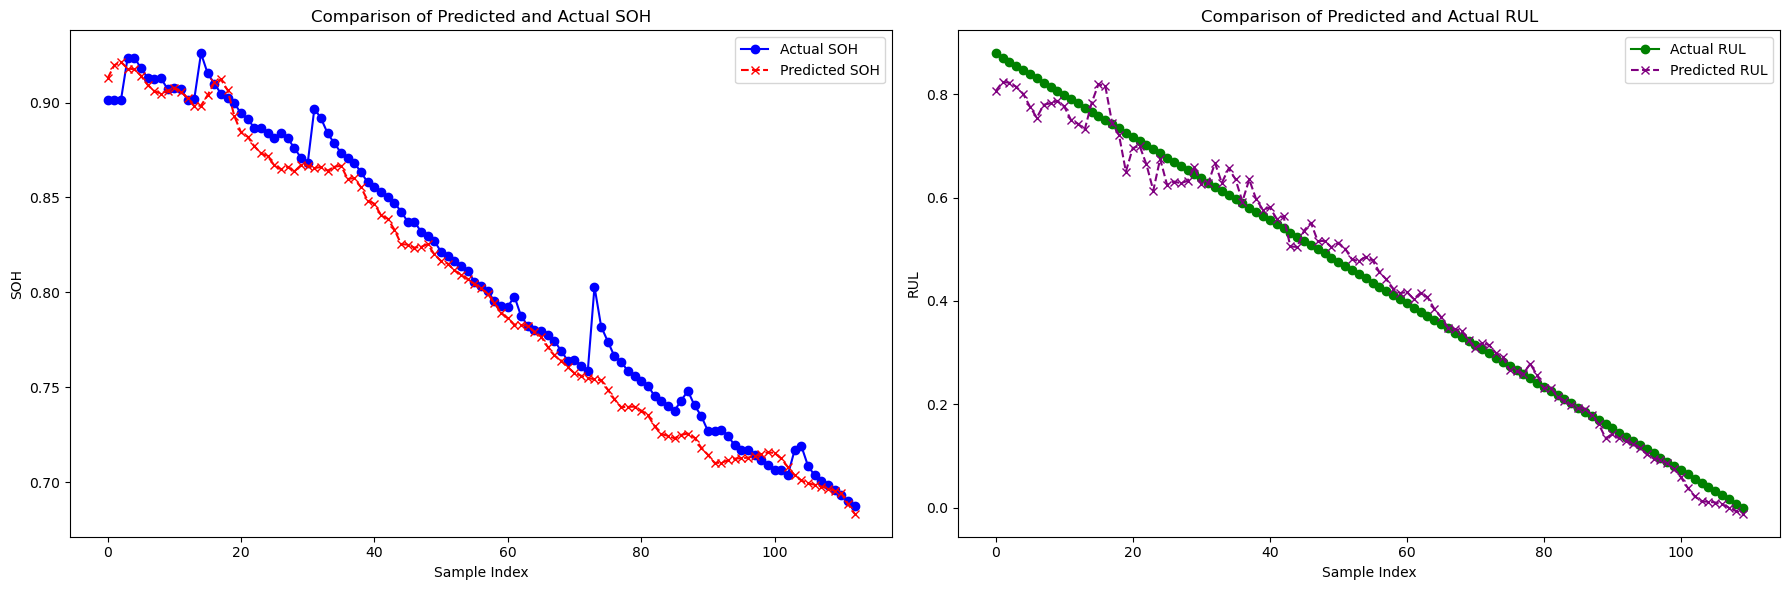

In [31]:
predictions_by_time = defaultdict(list)
true_by_time = defaultdict(list)
rul_preds = []
rul_true = []

model.eval()
with torch.no_grad():
    time_step = 0  # 初始化时间步
    for features, soh, rul in val_loader:
        soh_pred, rul_pred = model(features)
        
        # 转换为numpy数组以方便处理
        soh_pred = np.array(soh_pred)
        soh = np.array(soh)
        # 更新predictions_by_time
        for i in range(soh_pred.shape[0]):  # 遍历batch中的每个样本
            current_base_time = time_step + i
            for j in range(pred_len):  # 遍历每个样本的所有预测步
                predictions_by_time[current_base_time + j].append(soh_pred[i, j])
                true_by_time[current_base_time + j].append(soh[i, j])
        time_step += soh_pred.shape[0]  # 更新时间步
        
        rul_preds.extend(rul_pred.flatten().tolist())
        rul_true.extend(rul.tolist())

# 计算平均预测
average_predictions = {t: np.mean(vals) for t, vals in predictions_by_time.items()}
average_true = {t: np.mean(vals) for t, vals in true_by_time.items()}
soh_preds = list(average_predictions.values())
soh_true = list(average_true.values())

# 绘制SOH的预测与实际值对比图
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(soh_true, label='Actual SOH', color='blue', marker='o')
plt.plot(soh_preds, label='Predicted SOH', color='red', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual SOH')
plt.xlabel('Sample Index')
plt.ylabel('SOH')
plt.legend()

# 绘制RUL的预测与实际值对比图
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(rul_true, label='Actual RUL', color='green', marker='o')
plt.plot(rul_preds, label='Predicted RUL', color='purple', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.show()